In [1]:
import numpy
import zpp
%matplotlib inline
from pylab import *

import os
import importlib

importlib.reload(zpp)
import scipy.ndimage as ndimage


import astropy
from scipy.ndimage.measurements import center_of_mass as com

import scipy
from scipy.interpolate import interp2d as II



In [97]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray


In [98]:
path = "/Users/npk/Dropbox/Local Volume Mapper/Spectrograph/simulations/1-sep-2018/"

In [99]:
files = os.listdir(path)

In [101]:
waves = [.566, .6347, .7033, .772]
fields = [0., 12., 24., 36., 48., 60.]
ds = [0, 0.017, 0.033, 0.05]

In [203]:

res = {}
x = y = np.arange(250) - 125
for file in files:
    if file[0] != "W": continue
       
    sp = file.split("_")
    key = tuple(map(float,(sp[0][1:], sp[1][1:], sp[2][2:])))

    meta,img = zpp.read_image_analysis(path + file)
    print(key, meta["Total_Rays_Launched"])
    
    c = np.round(com(img)).astype(np.int) - 125
    rolledimg = np.roll(img, -c, (0,1))
    
    ff = II(x, y, img)
    c = np.array(com(img)) - 125
    new = ff(x+c[1], y+c[0])
    new = new/new.sum() * meta["Total_Rays_Launched"]
    
    res[key] = (meta, new)
        

(0.772, 0.0, 0.0) 200006975.0
(0.566, 48.0, 0.0017) 200006975.0
(0.566, 36.0, 0.0033) 200006975.0
(0.772, 12.0, 0.0033) 200006975.0
(0.7033, 48.0, 0.0033) 200006975.0
(0.772, 60.0, 0.005) 200006975.0
(0.7033, 36.0, 0.0017) 200006975.0
(0.566, 60.0, 0.005) 200006975.0
(0.7033, 24.0, 0.005) 200006975.0
(0.6347, 60.0, 0.0) 200006975.0
(0.7033, 12.0, 0.0017) 200006975.0
(0.772, 48.0, 0.0017) 200006975.0
(0.566, 12.0, 0.0033) 200006975.0
(0.772, 36.0, 0.0033) 200006975.0
(0.7033, 24.0, 0.0033) 200006975.0
(0.6347, 0.0, 0.0017) 200006975.0
(0.566, 60.0, 0.0033) 200006975.0
(0.566, 12.0, 0.005) 200006975.0
(0.772, 36.0, 0.005) 200006975.0
(0.566, 24.0, 0.0017) 200006975.0
(0.6347, 12.0, 0.0) 200006975.0
(0.7033, 60.0, 0.0017) 200006975.0
(0.566, 36.0, 0.005) 200006975.0
(0.772, 24.0, 0.0017) 200006975.0
(0.772, 12.0, 0.005) 200006975.0
(0.6347, 36.0, 0.0) 200006975.0
(0.7033, 48.0, 0.005) 200006975.0
(0.772, 60.0, 0.0033) 200006975.0
(0.7033, 36.0, 0.005) 200006975.0
(0.566, 0.0, 0.0) 2000069

In [204]:
def make_subplot(nrows, ncols, rownames, colnames, figsize=(15,9)):
    
    fig, axes = subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ax, col in zip(axes[0], colnames):
        ax.set_title(col)
    
    for ax, row in zip(axes[:,0], rownames):
        ax.set_ylabel(row)
        
    return axes, fig
    

# Determine SNR in one of these images

SNR per pixel of the central sections is 178.3
So that SNR per pixel after subtraction 126.1
And if we want 0.1% fluctuations to be detected at 5 sigma we need SNR=5000
So we need to bin by 28


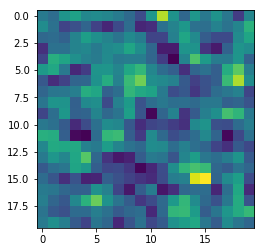

In [205]:
meta, img = res[(0.772, 0., 0.0)]


stamp = img[115:135,115:135]
imshow(stamp)
snr = np.mean(stamp)/np.std(stamp)



print("SNR per pixel of the central sections is %3.1f" % (snr))

print("So that SNR per pixel after subtraction %3.1f" % (snr/1.414))



print("And if we want 0.1% fluctuations to be detected at 5 sigma we need SNR=5000")
print("So we need to bin by %i" % (5000/snr))

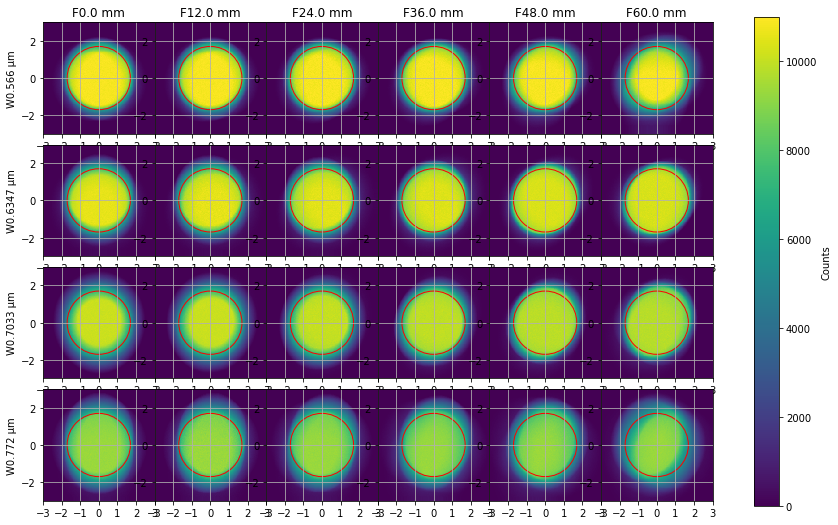

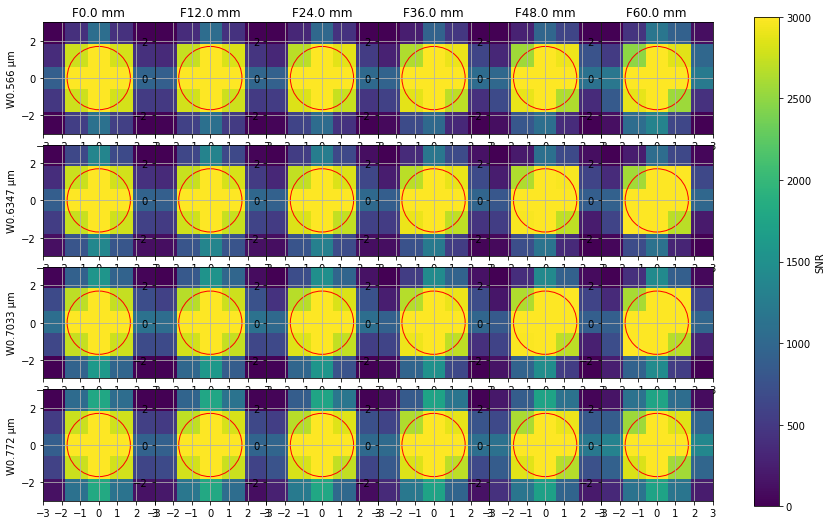

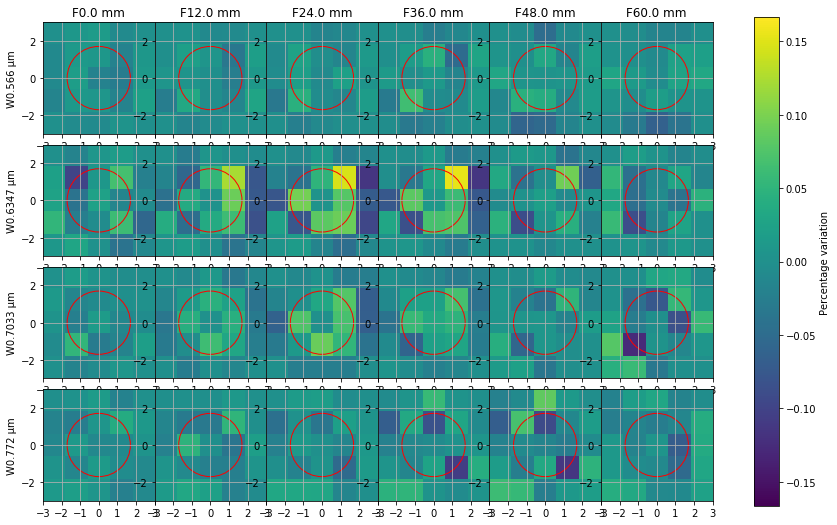

In [206]:

figsize = (12,15)

d1 = 0.0
d2 = 0.005

fnames = ["F%s mm" % field for field in fields]
wnames = ["W%s Âµm" % wave for wave in waves]
ticklocs = [-3,-2,-1,0,1,2,3]

axes, fig = make_subplot(len(waves), len(fields), wnames, fnames)
imshow_opt = {"extent": [-3,3,-3,3]}
subplotsadjust_opt = {"wspace": 0, "hspace": 0}
MAXSIGNAL = 11000.
for ix,w in enumerate(waves):
    for jx,f in enumerate(fields):
        img = res[(w,f,d1)][1]
        
        #subplot(len(waves), len(fields), cnt)
        im = axes[ix, jx].imshow(img, **imshow_opt, vmin=0, vmax=MAXSIGNAL)
        axes[ix,jx].add_artist(Circle((0,0), 1.7, fill=None, color='red'))
        axes[ix,jx].set_xticks(ticklocs)
        axes[ix,jx].grid(True)
        subplots_adjust(**subplotsadjust_opt)
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label("Counts")
        
"""
axes = make_subplot(len(waves), len(fields), wnames, fnames)
for ix,w in enumerate(waves):
    for jx,f in enumerate(fields):
        img = res[(w,f,d2)][1]
        
        axes[ix,jx].imshow(img, **imshow_opt) 
        axes[ix,jx].add_artist(Circle((0,0), 1.7, fill=None, color='red'))
        axes[ix,jx].set_xticks(ticklocs)
        axes[ix,jx].grid(True)
        subplots_adjust(**subplotsadjust_opt)
"""

BINSIZE = (5,5)
SNRMAX = 3000
axes, fig = make_subplot(len(waves), len(fields), wnames, fnames)
for ix,w in enumerate(waves):
    for jx,f in enumerate(fields):
        img1 = res[(w,f,d1)][1]
        
        d = bin_ndarray(img1, BINSIZE, operation="sum")
        #n.b. 5000 is the desired SNR
        im = axes[ix,jx].imshow(np.sqrt(d)/1.414, **imshow_opt, vmin=0, vmax=SNRMAX)
        axes[ix,jx].add_artist(Circle((0,0), 1.7, fill=None, color='red'))
        axes[ix,jx].set_xticks(ticklocs)
        axes[ix,jx].grid(True)
        subplots_adjust(**subplotsadjust_opt)

cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label("SNR")
        
axes, fig = make_subplot(len(waves), len(fields), wnames, fnames)
for ix,w in enumerate(waves):
    for jx,f in enumerate(fields):
        img1 = res[(w,f,d1)][1]
        img2 = res[(w,f,d2)][1]
        
        d = img1-img2            
        #d = ndimage.gaussian_filter(d, sigma=(5,5), order=0)
        d = bin_ndarray(d, (5, 5), operation="mean")
        
        im = axes[ix,jx].imshow(d/MAXSIGNAL*100, **imshow_opt, vmin=-5/SNRMAX*100, vmax=5/SNRMAX*100)
        axes[ix,jx].add_artist(Circle((0,0), 1.7, fill=None, color='red'))
        axes[ix,jx].set_xticks(ticklocs)
        axes[ix,jx].grid(True)
        subplots_adjust(**subplotsadjust_opt)

cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label("Percentage variation")


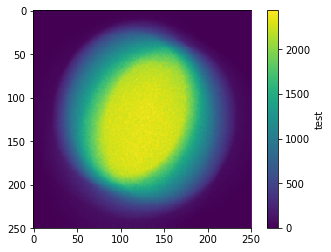

In [195]:
imshow(img)
cbar = colorbar()

cbar.set_label("test")

In [96]:
sqrt(250/10) * 200 / 1.414

707.2135785007073

In [84]:
x = np.arange(250)
ff = II(x, x, img1)

In [85]:
img_s = ff(x+.5,x+.1)

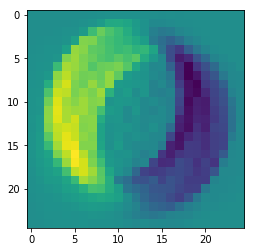

In [86]:
imshow(bin_ndarray(img_s-img1, (25,25)))

In [69]:
meta

{'Date': '9/5/2018',
 'Field_Width': <Quantity 0.117 mm>,
 'Image_Width': <Quantity 0.09 mm>,
 'Number_of_pixels': (250, 250),
 'Percent_Efficiency': <Quantity 99.92 %>,
 'Title': '2013/08/22 DESI Spectrograph f/3.57 (no corrector) Design',
 'Total_Rays_Launched': <Quantity 50003625.>,
 'Total_Weight_of_Rays_Attempted': <Quantity 50003630.>,
 'Total_Weight_of_Rays_Passed': <Quantity 49964440.>,
 'Total_flux_in_watts': <Quantity 0.9992>,
 'Units': <Quantity 1. W / mm2>}